# Intruduction to NLP fundamentals in TensorFlow
NLP has the goal of deriving information out of natural language (could be sequences of text or speech).

Another common term for NLP problems is sequence to sequence problems (seq2seq).

## Check for the GPU

In [1]:
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-72a6d20c-158d-0b5c-2c2d-f847d86483b9)


## Get helper functions

In [2]:
# Download the helper functions
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

# Import series of helper functions for the notebook
from helper_functions import unzip_data, create_tensorboard_callback, plot_loss_curves, compare_historys

--2023-03-23 18:10:59--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2023-03-23 18:10:59 (79.9 MB/s) - ‘helper_functions.py’ saved [10246/10246]



## Get a text dataset
The dataset we're going to be using is Kaggle's introduction to NLP dataset (text samples of Tweets labeled as disaster or not disaster).

See the orignal source here: https://www.kaggle.com/competitions/nlp-getting-started

In [3]:
# Download the data
!wget https://storage.googleapis.com/ztm_tf_course/nlp_getting_started.zip

# Unzip data
unzip_data('nlp_getting_started.zip')

--2023-03-23 18:11:04--  https://storage.googleapis.com/ztm_tf_course/nlp_getting_started.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.194.128, 74.125.200.128, 74.125.68.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.194.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 607343 (593K) [application/zip]
Saving to: ‘nlp_getting_started.zip’

nlp_getting_started 100%[===================>] 593.11K  --.-KB/s    in 0.005s  

2023-03-23 18:11:04 (117 MB/s) - ‘nlp_getting_started.zip’ saved [607343/607343]



## Become one with the data - visualize a text dataset

To visualize our text sample, we first need to read them in. One way to do so would be to use Python.

But we can get visual straight away.

So another way to do this is to use Pandas.

TF help: https://www.tensorflow.org/tutorials/load_data/text

In [4]:
import pandas as pd

train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

train_df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [5]:
train_df['text'][0]

'Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all'

In [6]:
train_df['text'][1]

'Forest fire near La Ronge Sask. Canada'

In [7]:
# Shuffle training dataframe
train_df_shuffled = train_df.sample(frac=1, 
                                    random_state=42)

train_df_shuffled.head()

,id,keyword,location,text,target
2644,3796,destruction,NaN,So you have a new weapon that can cause un-ima...,1
2227,3185,deluge,NaN,The f$&amp;@ing things I do for #GISHWHES Just...,0
5448,7769,police,UK,DT @georgegalloway: RT @Galloway4Mayor: ÛÏThe...,1
132,191,aftershock,NaN,Aftershock back to school kick off was great. ...,0
6845,9810,trauma,"Montgomery County, MD",in response to trauma Children of Addicts deve...,0


In [8]:
# What does the test dataset look like?
test_df.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [9]:
# How many examples are there?
train_df.target.value_counts()

0    4342
1    3271
Name: target, dtype: int64

If dataset is imbalanced: https://www.tensorflow.org/tutorials/structured_data/imbalanced_data

In [10]:
# How many total samples
len(train_df), len(test_df)

(7613, 3263)

In [11]:
# Let's visualize some random training examples
import random 
random_index = random.randint(0, len(train_df)-5) #create random indexes not higher then random number of samples

for row in train_df_shuffled[['text', 'target']][random_index:random_index+5].itertuples():
  _, text, target = row
  print(f"Target: {target}", "(real disaster)" if target > 0 else "(not real disaster)")
  print(f"Text: \n{text}\n")
  print("---\n")

Target: 0 (not real disaster)
Text: 
Wow! He crushed that! #EDWING #BlueJays

---

Target: 1 (real disaster)
Text: 
Adult dies of plague in Colorado http://t.co/yoHVuwuMZS

---

Target: 1 (real disaster)
Text: 
How American war planners singled out Hiroshima for destruction http://t.co/B5OKgpSpbH

---

Target: 0 (not real disaster)
Text: 
@Kaotix_Blaze craving u

---

Target: 0 (not real disaster)
Text: 
@mcnabbychic I fear not for a while

---



### Split data into training and validation sets

In [12]:
from sklearn.model_selection import train_test_split

In [13]:
# Use train_test_split to split the training data into training and validation sets
train_sentences, val_sentences, train_labels, val_labels = train_test_split(train_df_shuffled['text'],
                                                                            train_df_shuffled['target'],
                                                                            test_size=0.1,
                                                                            random_state=42)

In [14]:
# Check the lenghts
len(train_sentences), len(train_labels), len(val_sentences), len(val_labels)

(6851, 6851, 762, 762)

In [15]:
# Check some top samples
train_sentences[:10], train_labels[:10]

(5921    @mogacola @zamtriossu i screamed after hitting...
 3904              Imagine getting flattened by Kurt Zouma
 2804    @Gurmeetramrahim #MSGDoing111WelfareWorks Gree...
 3718    @shakjn @C7 @Magnums im shaking in fear he's g...
 1667    Somehow find you and I collide http://t.co/Ee8...
 4435    @EvaHanderek @MarleyKnysh great times until th...
 2544                     destroy the free fandom honestly
 7223    Weapons stolen from National Guard Armory in N...
 4265    @wfaaweather Pete when will the heat wave pass...
 6568    Patient-reported outcomes in long-term survivo...
 Name: text, dtype: object, 5921    0
 3904    0
 2804    1
 3718    0
 1667    0
 4435    1
 2544    1
 7223    0
 4265    1
 6568    1
 Name: target, dtype: int64)

## Converting text into numbers

When dealing with a text problem, one of the first things you'll have to do before you can build a model is to convert your text into numbers.

There are a few ways to do this, namely:
* Tokenization - direct mapping of token (a token could be a word or a character) to number
* Embeddings - create a matrix of feature vector for each token (the size of the feature vector can be defined and this embeddings can be learned)

### Text vectorizaton - tokenization

In [16]:
train_sentences[:5]

5921    @mogacola @zamtriossu i screamed after hitting...
3904              Imagine getting flattened by Kurt Zouma
2804    @Gurmeetramrahim #MSGDoing111WelfareWorks Gree...
3718    @shakjn @C7 @Magnums im shaking in fear he's g...
1667    Somehow find you and I collide http://t.co/Ee8...
Name: text, dtype: object

In [17]:
import tensorflow as tf
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

In [18]:
# Use the default TextVectorization parameters
text_vectorizer = TextVectorization(max_tokens=None, # how many words in the vocabulary (automaticall add <OOV>)
                                    standardize='lower_and_strip_punctuation',
                                    split='whitespace',
                                    ngrams=None, # create groups of n-words?
                                    output_mode='int', # how to map tokens to numbers
                                    output_sequence_length=None, # how long you want your sequences to be
                                    #pad_to_max_tokens=True
                                    )

In [19]:
# Find the average number of tokens (words) in the training tweets
round(sum([len(i.split()) for i in train_sentences])/len(train_sentences))

15

In [20]:
# Setup text vectorization variables
max_vocab_length = 10000 # max number of words in vocabulary
max_length = 15 # max length our sequences will be (e.g. for many words will a model see)

text_vectorizer = TextVectorization(max_tokens=max_vocab_length,
                                    output_mode='int',
                                    output_sequence_length=max_length)

In [21]:
# Fit the text vextorizer to the training set
text_vectorizer.adapt(train_sentences)

In [22]:
# Create a sample sentence and tokenize it
sample_sentence = "There's a flood in my street!"
text_vectorizer([sample_sentence])

<tf.Tensor: shape=(1, 15), dtype=int64, numpy=
array([[264,   3, 232,   4,  13, 698,   0,   0,   0,   0,   0,   0,   0,
          0,   0]])>

In [23]:
# Choose a random sentence from the training dataset and tokenize it
random_sentence = random.choice(train_sentences)
print(f"Original text:\n {random_sentence}\
      \n\nVectorized version: ")
text_vectorizer([random_sentence])

Original text:
 @fuckyeahcarey @BornVerified drake killing this dude and tea bagging the dead body at this point      

Vectorized version: 


<tf.Tensor: shape=(1, 15), dtype=int64, numpy=
array([[   1,    1, 1028, 1277,   19, 1087,    7, 2267,  490,    2,  115,
          83,   17,   19, 1491]])>

In [24]:
# Get the unique words in the vocabulary
words_in_vocab = text_vectorizer.get_vocabulary() # get all of the unique words in training data
top_5_words = words_in_vocab[:5] # most 5 common words
bottom_5_words = words_in_vocab[-5:]

print(f"Number of words in vocab: {len(words_in_vocab)}")
print(f"Top 5 most common words are: {top_5_words}")
print(f"Top 5 least common words are: {bottom_5_words}")

Number of words in vocab: 10000
Top 5 most common words are: ['', '[UNK]', 'the', 'a', 'in']
Top 5 least common words are: ['pages', 'paeds', 'pads', 'padres', 'paddytomlinson1']


### Create and Embedding using and Embedding Layer
To make our embedding we're going to use TensorFlow's Embedding Layer.

Parameters we care the most are:
* `input_dim` = the size of our vocabulary
* `output_dim` = the size of the output embedding vector, for example: a value of 100 would mean each token gets represented by a vector 100 long
* `input_length` = length of sequences being passes to the embedding layer

In [25]:
from tensorflow.keras import layers

embedding = layers.Embedding(input_dim=max_vocab_length, # set input shape
                             output_dim=128, # output shape
                             input_length=max_length #how long in each input
                             )

embedding

In [26]:
# Get another random sentence
random_sentence = random.choice(train_sentences)
print(f"Original text: {random_sentence}")
print(f"Embedded version: ")

# Embed the random sentence (turn it into the dense vector of fixed size)
sample_embed = embedding(text_vectorizer([random_sentence]))
sample_embed

Original text: @gideonstrumpet Have you been held hostage?
Embedded version: 


<tf.Tensor: shape=(1, 15, 128), dtype=float32, numpy=
array([[[ 0.0268706 ,  0.0032748 ,  0.00840636, ..., -0.03336246,
          0.00094802, -0.02024729],
        [ 0.0146911 , -0.04028127, -0.01629146, ..., -0.00396746,
          0.00758702, -0.03915589],
        [ 0.03863369,  0.00524802,  0.01745937, ...,  0.03456389,
         -0.04297801, -0.00307428],
        ...,
        [ 0.01728651, -0.04341143, -0.03024361, ...,  0.03326905,
          0.02096115,  0.03005853],
        [ 0.01728651, -0.04341143, -0.03024361, ...,  0.03326905,
          0.02096115,  0.03005853],
        [ 0.01728651, -0.04341143, -0.03024361, ...,  0.03326905,
          0.02096115,  0.03005853]]], dtype=float32)>

In [27]:
# Check out a single token's embedding
sample_embed[0][0], sample_embed[0][0].shape, random_sentence

(<tf.Tensor: shape=(128,), dtype=float32, numpy=
 array([ 0.0268706 ,  0.0032748 ,  0.00840636,  0.02735518,  0.03049782,
        -0.02326189,  0.01354561, -0.02958814, -0.04508702,  0.04534194,
         0.0175048 ,  0.04748062, -0.04008033, -0.03137406, -0.00047022,
         0.01801231, -0.00316895,  0.00317182,  0.03066787, -0.00643482,
        -0.00274337,  0.01952492,  0.03884811,  0.03453938,  0.00814237,
        -0.0280175 , -0.00196224,  0.0376556 , -0.0467959 ,  0.00178052,
         0.03587252,  0.03775162,  0.01142775, -0.03842961,  0.0091783 ,
         0.00684261,  0.03211132,  0.0018541 , -0.03392322, -0.04882158,
        -0.01465652,  0.03202434, -0.01583242,  0.03083218, -0.00697416,
         0.01312819, -0.01265459,  0.03927768, -0.01514603,  0.02170558,
        -0.00202354, -0.04909171,  0.0146798 ,  0.02379018, -0.03213727,
         0.0309679 , -0.03863927,  0.01275059,  0.01569326,  0.02265019,
        -0.03934123, -0.04975907, -0.0257104 , -0.02140213,  0.03812971,
  

## Modelling a text dataset (running a bunch of experiments)

Now we've got a way to turn our text sequences into numbers, it's time to start building a series of modelling experiments.

We'll start with a baseline and move on from there.

* Model 0: Naive Bayes (baseline), this is from Sklearn ML Map
* Model 1: Feed-forward neural network (dense model)
* Model 2: LSTM Model (RNN)
* Model 3: GRU Model (RNN)
* Model 4: Bidirectional-LSTM (RNN)
* Model 5: 1D Convolutional Neural Network (CNN)
* Model 6: TensorFlow Hub Pretrained feature Extractor (using transfer learning for NLP)
* Model 7: Same as model 6, but with 10% training data

### Model 0: getting a baseline

As with all machine learning modelling experiments, it's important to create a baseline model so you've got a benchmark for future experiments to build upon. 

To create our baseline, we'll use Sklearn's Multinomial Naive Bayes using the TF-IDF formula to convert our words to numbers.

> **NOTE:** It's common practice to use non-DL algorythms as a baseline model because of their speed and then later using DL to see if you can improve upon them.


In [28]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

# Create tokenization and modelling pipeline
model_0 = Pipeline([
    ('tfidf', TfidfVectorizer()), # convert words to numbers using TF-IDF
    ('clf', MultinomialNB()) # model the text
])

# Fit the pipeline to the data
model_0.fit(train_sentences, train_labels)

Pipeline(steps=[('tfidf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [29]:
# Evaluate our baseline model
baseline_score = model_0.score(val_sentences, val_labels)
print(f"Our baseline model achieves an accuracy of: {baseline_score*100:.2f}%")

Our baseline model achieves an accuracy of: 79.27%


In [30]:
# Make predictions 
baseline_preds = model_0.predict(val_sentences)
baseline_preds[:20]

array([1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1])

### Creating an evaluation function for our model experiments

We could evaluate all of our model's predictions with different metrics every time. However this may bu cumbersom and will surely take some time.

Let's create one to compare our model's predcitions with truth labels using the following metrics:
* Accuracy
* Precision
* Recall
* F1-score

In [31]:
# Function to evaluate: accuracy, recall, precision, f1-score

from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def calculate_results(y_true, y_pred):
  """
  Calculate model accuracy, recall, precision and f1-score of a binary classification model.
  """
  # Calculate model accuracy
  model_accuracy = accuracy_score(y_true, y_pred) * 100

  # Calculate precision, recall and f1-score using 'weighted' metrics
  model_precision, model_recall, model_f1, _ = precision_recall_fscore_support(y_true, y_pred, average='weighted')

  model_results = {'accuracy': model_accuracy,
                   'precision': model_precision,
                   'recall': model_recall,
                   'f1': model_f1}

  return model_results

In [32]:
# Get baseline results
baseline_results = calculate_results(y_true=val_labels,
                                     y_pred=baseline_preds)

baseline_results

{'accuracy': 79.26509186351706,
 'precision': 0.8111390004213173,
 'recall': 0.7926509186351706,
 'f1': 0.7862189758049549}

### Model 1: A simple dense model

In [33]:
# Create a tensorboard callback (need to create new one for each model)
from helper_functions import create_tensorboard_callback

# Create a directory to save TensorBoard logs
SAVE_DIR = "model_logs"

In [34]:
# Build model with Functional API
from tensorflow.keras import layers

inputs = layers.Input(shape=(1,), dtype=tf.string) # inputs are 1-dimensional strings
x = text_vectorizer(inputs) # turn the input text into numbers
x = embedding(x) # create an embedding of numberized inputs
x = layers.GlobalAveragePooling1D()(x) # condense the feature vector for each token to each vector
outputs = layers.Dense(1, activation='sigmoid')(x) # create the output layer, want binary output so sigmoid

model_1 = tf.keras.Model(inputs, outputs, name='model_1_dense')

In [35]:
model_1.summary()

Model: "model_1_dense"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (TextV  (None, 15)               0         
 ectorization)                                                   
                                                                 
 embedding (Embedding)       (None, 15, 128)           1280000   
                                                                 
 global_average_pooling1d (G  (None, 128)              0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 1,280,129
Trainable params: 1,280,129
N

In [36]:
# Compile model
model_1.compile(loss='binary_crossentropy',
                optimizer='Adam',
                metrics=['accuracy'])

In [37]:
# Fit the model
model_1_history = model_1.fit(x=train_sentences,
                              y=train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(dir_name=SAVE_DIR,
                                                                     experiment_name='model_1_dense')])

Saving TensorBoard log files to: model_logs/model_1_dense/20230323-181112
Epoch 1/5
215/215 [==============================] - 21s 62ms/step - loss: 0.6106 - accuracy: 0.6919 - val_loss: 0.5358 - val_accuracy: 0.7612
Epoch 2/5
215/215 [==============================] - 2s 8ms/step - loss: 0.4407 - accuracy: 0.8229 - val_loss: 0.4693 - val_accuracy: 0.7822
Epoch 3/5
215/215 [==============================] - 2s 9ms/step - loss: 0.3466 - accuracy: 0.8628 - val_loss: 0.4616 - val_accuracy: 0.7913
Epoch 4/5
215/215 [==============================] - 2s 8ms/step - loss: 0.2839 - accuracy: 0.8915 - val_loss: 0.4647 - val_accuracy: 0.7861
Epoch 5/5
215/215 [==============================] - 2s 7ms/step - loss: 0.2374 - accuracy: 0.9104 - val_loss: 0.4814 - val_accuracy: 0.7822


In [38]:
# Check the results
model_1.evaluate(val_sentences, val_labels)

24/24 [==============================] - 0s 3ms/step - loss: 0.4814 - accuracy: 0.7822


[0.48144686222076416, 0.7821522355079651]

In [39]:
# Make some predictions and evaluate those
model_1_pred_probs = model_1.predict(val_sentences)
model_1_pred_probs[:10]

24/24 [==============================] - 0s 2ms/step


array([[0.42333716],
       [0.7434322 ],
       [0.9975514 ],
       [0.11492206],
       [0.11276284],
       [0.9461413 ],
       [0.9321786 ],
       [0.9932848 ],
       [0.9705577 ],
       [0.2740033 ]], dtype=float32)

In [40]:
# Single prediction
model_1_pred_probs[1]

array([0.7434322], dtype=float32)

In [41]:
# Convert model prediction probabilities to label format
model_1_preds = tf.squeeze(tf.round(model_1_pred_probs))
model_1_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 0., 1., 1., 1., 1., 0.], dtype=float32)>

In [42]:
# Calculate our model_1 results
model_1_results = calculate_results(y_true=val_labels,
                                    y_pred=model_1_preds)
model_1_results

{'accuracy': 78.21522309711287,
 'precision': 0.7856661242905698,
 'recall': 0.7821522309711286,
 'f1': 0.7795215466562155}

In [43]:
import numpy as np
np.array(list(model_1_results.values()))> np.array(list(baseline_results.values()))

array([False, False, False, False])

## Visualizing learned embeddings

In [44]:
# Get the vocabulary from the text vectorization layer
words_in_vocab = text_vectorizer.get_vocabulary()
len(words_in_vocab), words_in_vocab[:10]

(10000, ['', '[UNK]', 'the', 'a', 'in', 'to', 'of', 'and', 'i', 'is'])

In [45]:
# Model_1 summary
model_1.summary()

Model: "model_1_dense"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (TextV  (None, 15)               0         
 ectorization)                                                   
                                                                 
 embedding (Embedding)       (None, 15, 128)           1280000   
                                                                 
 global_average_pooling1d (G  (None, 128)              0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 1,280,129
Trainable params: 1,280,129
N

In [46]:
# Get the weight matrix of embedding layer
# (these are the numerical representation of each token in our training data
# which have been learned for 5 epochs)
embed_weights = model_1.get_layer('embedding').get_weights()[0]
embed_weights

array([[ 0.0331966 , -0.0298713 , -0.04639115, ...,  0.01853889,
         0.0378896 ,  0.01469729],
       [ 0.02745574,  0.00366913,  0.00875372, ..., -0.03454575,
         0.00318723, -0.02168543],
       [ 0.00533818, -0.02953026, -0.05186268, ...,  0.02307615,
         0.05411595, -0.05607378],
       ...,
       [ 0.02019143,  0.02777174,  0.00536128, ..., -0.00438382,
         0.03611991, -0.018668  ],
       [ 0.02191117,  0.00368049, -0.00352239, ..., -0.02710621,
         0.08135545,  0.00699374],
       [ 0.01652465,  0.07584143, -0.0792587 , ..., -0.06281253,
         0.03161809, -0.07313044]], dtype=float32)

In [47]:
embed_weights.shape # same size as vocab size and embedding_dim (output_dim of our embedding layer)

(10000, 128)

Now we've got the embedding matrix, our model has learned to represent our tokens. Let's see how we can visualize it.

To do so, TensorFlow has a handy tool called projector: http://projector.tensorflow.org/

And TensorFlow also has an incredible guide on word embeddings themselves.

In [48]:
# Code straight from TensorFlow documentation
# Create embedding files
import io

out_v = io.open('vectors.tsv', 'w', encoding='utf-8')
out_m = io.open('metadata.tsv', 'w', encoding='utf-8')

for index, word in enumerate(words_in_vocab):
  if index == 0:
    continue  # skip 0, it's padding.
  vec = embed_weights[index]
  out_v.write('\t'.join([str(x) for x in vec]) + "\n")
  out_m.write(word + "\n")
out_v.close()
out_m.close()

In [49]:
# Download files from Colab to import them to Projector
# Code straight from TensorFlow documentation
try:
  from google.colab import files
  files.download('vectors.tsv')
  files.download('metadata.tsv')
except Exception:
  pass

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Recurrent Neural Networks (RNN's)

RNN's are useful for sequential data.

The premise of a recurrent neural network is to use the representation of a precious input to aid the representation of a later input.

### Model 2: LSTM

LSTM = Long short term memory (one of the most popular RNN cells).

Our structure of an RNN typically looks like this:

```
Input (text) -> Tokenize -> Embedding -> Layers (RNNs/Dense) -> Output (label probability)



In [50]:
# Create an LSTM model

from tensorflow.keras import layers

inputs = layers.Input(shape=(1,), dtype='string')
x = text_vectorizer(inputs)
x = embedding(x)
#print(x.shape)
#x = layers.LSTM(units=64, return_sequences=True)(x) # when you're stacking RNN cells together, you need to return_sequences=True
#print(x.shape)
x = layers.LSTM(64)(x)
#print(x.shape)
#x = layers.Dense(64, activation='relu')(x)
#print(x.shape)
outputs = layers.Dense(1, activation='sigmoid')(x)

model_2 = tf.keras.Model(inputs, outputs, name='model_2_LSTM')

In [51]:
# Get a summary
model_2.summary()

Model: "model_2_LSTM"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (TextV  (None, 15)               0         
 ectorization)                                                   
                                                                 
 embedding (Embedding)       (None, 15, 128)           1280000   
                                                                 
 lstm (LSTM)                 (None, 64)                49408     
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 1,329,473
Trainable params: 1,329,473
Non-trainable params: 0
____________________________________________

In [52]:
# Compile the model
model_2.compile(loss='binary_crossentropy',
                optimizer='Adam',
                metrics=['accuracy'])

In [53]:
# Fit the model
model_2_history = model_2.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR, 
                                                                     'model_2_LSTM')])

Saving TensorBoard log files to: model_logs/model_2_LSTM/20230323-181157
Epoch 1/5
215/215 [==============================] - 13s 43ms/step - loss: 0.2182 - accuracy: 0.9229 - val_loss: 0.5623 - val_accuracy: 0.7756
Epoch 2/5
215/215 [==============================] - 3s 15ms/step - loss: 0.1559 - accuracy: 0.9444 - val_loss: 0.6594 - val_accuracy: 0.7808
Epoch 3/5
215/215 [==============================] - 3s 11ms/step - loss: 0.1277 - accuracy: 0.9499 - val_loss: 0.6792 - val_accuracy: 0.7730
Epoch 4/5
215/215 [==============================] - 2s 10ms/step - loss: 0.1037 - accuracy: 0.9591 - val_loss: 0.7806 - val_accuracy: 0.7782
Epoch 5/5
215/215 [==============================] - 2s 7ms/step - loss: 0.0847 - accuracy: 0.9656 - val_loss: 0.9881 - val_accuracy: 0.7769


In [54]:
# Make predictions with LSTM model
model_2_pred_probs = model_2.predict(val_sentences)
model_2_pred_probs[:10]

24/24 [==============================] - 0s 3ms/step


array([[2.1222461e-02],
       [8.7781811e-01],
       [9.9989223e-01],
       [4.7616504e-02],
       [3.7370724e-04],
       [9.9943095e-01],
       [9.3338293e-01],
       [9.9989951e-01],
       [9.9984539e-01],
       [6.6623950e-01]], dtype=float32)

In [55]:
# Convert model_2 pred probs to labels
model_2_preds = tf.squeeze(tf.round(model_2_pred_probs))
model_2_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 0., 1., 1., 1., 1., 1.], dtype=float32)>

In [56]:
# Calculate model_2 results
model_2_results = calculate_results(y_true=val_labels,
                                    y_pred=model_2_preds)
model_2_results

{'accuracy': 77.69028871391076,
 'precision': 0.7772431692902212,
 'recall': 0.7769028871391076,
 'f1': 0.7756776970544694}

In [57]:
baseline_results

{'accuracy': 79.26509186351706,
 'precision': 0.8111390004213173,
 'recall': 0.7926509186351706,
 'f1': 0.7862189758049549}

### Model 3: GRU
Another popular and effective RNN component is the GRU layer (or Gated Recurrent Unit).

The GRU cell has similar features to LSTM cell but has less parameters.

In [58]:
# Build an RNN using the GRU cell
from tensorflow.keras import layers

inputs = layers.Input(shape=(1,), dtype=tf.string)
x = text_vectorizer(inputs)
x = embedding(x)
#x = layers.GRU(64, return_sequences=True)(x) # return_sequences=True if stacking layers
#x = layers.LSTM(64, return_sequences=True)(x)
#x = layers.GRU(64)(x)
#x = layers.Dense(64, activation='relu')(x)
#x = layers.GlobalAveragePooling1D()(x)
x = layers.GRU(64)(x)
outputs = layers.Dense(1, activation='sigmoid')(x)

model_3 = tf.keras.Model(inputs, outputs, name='model_3_GRU')

In [59]:
# Check the summary
model_3.summary()

Model: "model_3_GRU"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (TextV  (None, 15)               0         
 ectorization)                                                   
                                                                 
 embedding (Embedding)       (None, 15, 128)           1280000   
                                                                 
 gru (GRU)                   (None, 64)                37248     
                                                                 
 dense_2 (Dense)             (None, 1)                 65        
                                                                 
Total params: 1,317,313
Trainable params: 1,317,313
Non-trainable params: 0
_____________________________________________

In [60]:
# Compile the model
model_3.compile(loss='binary_crossentropy',
                optimizer='Adam',
                metrics=['accuracy'])

In [61]:
# Fit the model
model_3_history = model_3.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR,
                                                                     'model_3_GRU')])

Saving TensorBoard log files to: model_logs/model_3_GRU/20230323-181220
Epoch 1/5
215/215 [==============================] - 11s 38ms/step - loss: 0.1503 - accuracy: 0.9444 - val_loss: 0.9061 - val_accuracy: 0.7730
Epoch 2/5
215/215 [==============================] - 2s 11ms/step - loss: 0.0828 - accuracy: 0.9701 - val_loss: 0.7778 - val_accuracy: 0.7717
Epoch 3/5
215/215 [==============================] - 2s 8ms/step - loss: 0.0713 - accuracy: 0.9726 - val_loss: 0.9031 - val_accuracy: 0.7690
Epoch 4/5
215/215 [==============================] - 2s 11ms/step - loss: 0.0638 - accuracy: 0.9745 - val_loss: 1.0692 - val_accuracy: 0.7717
Epoch 5/5
215/215 [==============================] - 1s 7ms/step - loss: 0.0540 - accuracy: 0.9774 - val_loss: 1.1399 - val_accuracy: 0.7664


In [62]:
# Make predictions with GRU model
model_3_pred_probs = model_3.predict(val_sentences)
model_3_pred_probs[:10]

24/24 [==============================] - 0s 3ms/step


array([[4.8477470e-04],
       [7.1199161e-01],
       [9.9982709e-01],
       [6.5311372e-02],
       [1.3412285e-04],
       [9.9965167e-01],
       [7.9761380e-01],
       [9.9993157e-01],
       [9.9984431e-01],
       [8.8545740e-01]], dtype=float32)

In [63]:
# Convert model 3 pred probs to labels
model_3_preds = tf.squeeze(tf.round(model_3_pred_probs))
model_3_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 0., 1., 1., 1., 1., 1.], dtype=float32)>

In [64]:
# Calculate model 3 results
model_3_results = calculate_results(y_true=val_labels,
                                    y_pred=model_3_preds)
model_3_results

{'accuracy': 76.64041994750657,
 'precision': 0.7667302683900181,
 'recall': 0.7664041994750657,
 'f1': 0.7650123935123555}

### Model 4: Bidirectional RNN

Normal RNNs go from left to right (just the same way you read an English sentence). However, bidirectional RNN goes from right to left as well as from left to right.

In [65]:
# Create a bidirectional RNN model 4
from tensorflow.keras import layers

inputs = layers.Input(shape=(1,), dtype=tf.string)
x = text_vectorizer(inputs)
x = embedding(x)
x = layers.Bidirectional(layers.LSTM(64))(x)
outputs = layers.Dense(1, activation='sigmoid')(x)

model_4 = tf.keras.Model(inputs, outputs, name='model_4_bidirectional')

In [66]:
# Check the summary
model_4.summary()

Model: "model_4_bidirectional"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (TextV  (None, 15)               0         
 ectorization)                                                   
                                                                 
 embedding (Embedding)       (None, 15, 128)           1280000   
                                                                 
 bidirectional (Bidirectiona  (None, 128)              98816     
 l)                                                              
                                                                 
 dense_3 (Dense)             (None, 1)                 129       
                                                                 
Total params: 1,378,945
Trainable params: 1,3

In [67]:
# Compile the model
model_4.compile(loss='binary_crossentropy',
                optimizer='Adam',
                metrics=['accuracy'])

In [68]:
# Fit the model
model_4_history = model_4.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR,
                                                                     'model_4_bidirectional')])

Saving TensorBoard log files to: model_logs/model_4_bidirectional/20230323-181240
Epoch 1/5
215/215 [==============================] - 12s 39ms/step - loss: 0.1037 - accuracy: 0.9686 - val_loss: 0.9731 - val_accuracy: 0.7664
Epoch 2/5
215/215 [==============================] - 3s 14ms/step - loss: 0.0515 - accuracy: 0.9777 - val_loss: 1.3758 - val_accuracy: 0.7664
Epoch 3/5
215/215 [==============================] - 2s 10ms/step - loss: 0.0453 - accuracy: 0.9781 - val_loss: 1.1455 - val_accuracy: 0.7638
Epoch 4/5
215/215 [==============================] - 2s 11ms/step - loss: 0.0441 - accuracy: 0.9800 - val_loss: 1.2441 - val_accuracy: 0.7756
Epoch 5/5
215/215 [==============================] - 3s 12ms/step - loss: 0.0450 - accuracy: 0.9794 - val_loss: 1.2055 - val_accuracy: 0.7651


In [69]:
# Make predicitons
model_4_pred_probs = model_4.predict(val_sentences)
model_4_pred_probs[:10]

24/24 [==============================] - 1s 3ms/step


array([[9.6988823e-04],
       [6.4772564e-01],
       [9.9997044e-01],
       [1.1206186e-01],
       [4.1166164e-05],
       [9.8611152e-01],
       [1.0164898e-01],
       [9.9998927e-01],
       [9.9991941e-01],
       [8.6686754e-01]], dtype=float32)

In [70]:
# Convert predictions
model_4_preds = tf.squeeze(tf.round(model_4_pred_probs))
model_4_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 0., 1., 0., 1., 1., 1.], dtype=float32)>

In [71]:
# Calculate results
model_4_results = calculate_results(y_true=val_labels,
                                    y_pred=model_4_preds)
model_4_results

{'accuracy': 76.50918635170603,
 'precision': 0.7678247467805763,
 'recall': 0.7650918635170604,
 'f1': 0.7623298399088922}

## Convolutional Neural Networks for Text (and other sequences)

We've used CNNs for images, but images are typically 1D (H x W), however our text data is 1D.

Previoulsy we've used `Conv2D()` for image data but now we're going to use `Conv1D()` as data is 1-dimensional.

The typical structure of a Conv1D model for sequences (in our case, text):
```
Inputs (text) -> Tokenization -> Embedding -> Layer(s) (typically Conv1D + pooling) -> Outputs
```

### Model 5: 1D Convolutional Neural Network

In [72]:
# Test out our embedding layer, Conv1D layer and MaxPooling
from tensorflow.keras import layers

embedding_test = embedding(text_vectorizer(['this is a test sequence'])) # turn target sequence into embedding
conv_1d = layers.Conv1D(filters=32,
                        kernel_size=5, # also referred as an ngram=5 (looks at 5 words at a time)
                        strides=1, # default
                        activation='relu',
                        padding='same') # default = valid, output is smaller than input, same -> input is same shape as output
conv_1d_output = conv_1d(embedding_test) # pass embedding through Conv1D layer
max_pool = layers.GlobalMaxPooling1D()
max_pool_output = max_pool(conv_1d_output) # equaivalent to 'get the most important feature/feature with the highest value'

embedding_test.shape, conv_1d_output.shape, max_pool_output.shape

(TensorShape([1, 15, 128]), TensorShape([1, 15, 32]), TensorShape([1, 32]))

In [73]:
#embedding_test

In [74]:
#conv_1d_output

In [75]:
#max_pool_output

In [76]:
# Create 1-dimensional convolutional layer to model sequences
from tensorflow.keras import layers

inputs = layers.Input(shape=(1,), dtype=tf.string)
x = text_vectorizer(inputs)
x = embedding(x)
x = layers.Conv1D(filters=64,
                  kernel_size=5,
                  activation='relu',
                  padding='valid',
                  strides=1)(x)
x = layers.GlobalMaxPool1D()(x)
# x = layers.Dense(64, activation='relu')(x)
outputs = layers.Dense(1, activation='sigmoid')(x)

model_5 = tf.keras.Model(inputs, outputs, name='model_5_Conv1D')

# Compile Conv1D
model_5.compile(loss='binary_crossentropy',
                optimizer='Adam',
                metrics=['accuracy'])

# Summary
model_5.summary()

Model: "model_5_Conv1D"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (TextV  (None, 15)               0         
 ectorization)                                                   
                                                                 
 embedding (Embedding)       (None, 15, 128)           1280000   
                                                                 
 conv1d_1 (Conv1D)           (None, 11, 64)            41024     
                                                                 
 global_max_pooling1d_1 (Glo  (None, 64)               0         
 balMaxPooling1D)                                                
                                                                 
 dense_4 (Dense)             (None, 1)              

In [77]:
# Fit the model
model_5_history = model_5.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR,
                                                                     'model_5_Conv1D')])

Saving TensorBoard log files to: model_logs/model_5_Conv1D/20230323-181307
Epoch 1/5
215/215 [==============================] - 11s 38ms/step - loss: 0.1223 - accuracy: 0.9612 - val_loss: 0.9104 - val_accuracy: 0.7677
Epoch 2/5
215/215 [==============================] - 2s 9ms/step - loss: 0.0740 - accuracy: 0.9721 - val_loss: 1.0480 - val_accuracy: 0.7703
Epoch 3/5
215/215 [==============================] - 2s 10ms/step - loss: 0.0611 - accuracy: 0.9755 - val_loss: 1.1605 - val_accuracy: 0.7572
Epoch 4/5
215/215 [==============================] - 1s 7ms/step - loss: 0.0548 - accuracy: 0.9783 - val_loss: 1.1875 - val_accuracy: 0.7507
Epoch 5/5
215/215 [==============================] - 2s 10ms/step - loss: 0.0516 - accuracy: 0.9791 - val_loss: 1.1894 - val_accuracy: 0.7559


In [78]:
# Make predictions
model_5_pred_probs = model_5.predict(val_sentences)
model_5_pred_probs[:10]

24/24 [==============================] - 0s 4ms/step


array([[2.1293364e-01],
       [9.3084341e-01],
       [9.9994218e-01],
       [6.8957694e-02],
       [1.1438126e-07],
       [9.9395412e-01],
       [9.7604877e-01],
       [9.9998581e-01],
       [9.9999869e-01],
       [7.9790777e-01]], dtype=float32)

In [79]:
# Convert predictions
model_5_preds = tf.squeeze(tf.round(model_5_pred_probs))
model_5_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 0., 1., 1., 1., 1., 1.], dtype=float32)>

In [80]:
# Calculate the results
model_5_results = calculate_results(y_true=val_labels,
                                    y_pred=model_5_preds)
model_5_results

{'accuracy': 75.59055118110236,
 'precision': 0.7557293707913207,
 'recall': 0.7559055118110236,
 'f1': 0.7547819586377322}

## Model 6 - TensorFlow Hub Pretrained Sentence Encoder

Now we've built some of our own models, let's try and use transfer learning for NLP, specifically using Universal Sentence Encoder (or USE for short).

In [81]:
 import tensorflow_hub as hub
 embed = hub.load('https://tfhub.dev/google/universal-sentence-encoder/4')
 embed_samples = embed([sample_sentence, 'When you call the universal sentence encoder on a sentence, it turns it into numbers.'])

 print(embed_samples[0][:50])

tf.Tensor(
[-0.01157028  0.0248591   0.02878048 -0.012715    0.03971538  0.0882776
  0.02680984  0.05589836 -0.0106873  -0.00597291  0.00639323 -0.01819518
  0.00030813  0.09105888  0.05874644 -0.03180628  0.01512474 -0.05162929
  0.00991367 -0.06865347 -0.04209306  0.02678981  0.03011006  0.00321069
 -0.00337973 -0.04787357  0.0226672  -0.00985925 -0.04063613 -0.01292092
 -0.04666384  0.05630299 -0.03949255  0.00517686  0.02495829 -0.0701444
  0.02871508  0.04947684 -0.00633979 -0.08960192  0.02807118 -0.00808364
 -0.01360602  0.0599865  -0.10361787 -0.05195374  0.00232954 -0.02332531
 -0.03758105  0.03327728], shape=(50,), dtype=float32)


In [82]:
embed_samples

<tf.Tensor: shape=(2, 512), dtype=float32, numpy=
array([[-0.01157028,  0.0248591 ,  0.02878048, ..., -0.00186124,
         0.02315826, -0.01485021],
       [ 0.03596687, -0.08579467, -0.0115274 , ..., -0.03414333,
         0.02816025, -0.00878945]], dtype=float32)>

In [83]:
embed_samples.shape

TensorShape([2, 512])

In [84]:
# Create a Keras Layer using the USE pretrained layer from TensorFlow Hub
sentence_encoder_layer = hub.KerasLayer('https://tfhub.dev/google/universal-sentence-encoder/4', 
                                       input_shape=[], 
                                       dtype=tf.string,
                                       trainable=False,
                                       name='USE')

In [85]:
# Create model using Sequential API
model_6 = tf.keras.Sequential([
    sentence_encoder_layer,
    layers.Dense(128, activation='relu'),
    #layers.Dense(64, activation='relu'),
    layers.Dense(1, activation='sigmoid', name='output_layer')
], name='model_6_USE')

# Compile the model
model_6.compile(loss='binary_crossentropy',
                optimizer='Adam',
                metrics=['accuracy'])

# Summary
model_6.summary()

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


Model: "model_6_USE"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 USE (KerasLayer)            (None, 512)               256797824 
                                                                 
 dense_5 (Dense)             (None, 128)               65664     
                                                                 
 output_layer (Dense)        (None, 1)                 129       
                                                                 
Total params: 256,863,617
Trainable params: 65,793
Non-trainable params: 256,797,824
_________________________________________________________________


In [86]:
# Train the classifier on top of USE pretrained embeddings
model_6_history = model_6.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR,
                                                                     'model_6_USE')])

Saving TensorBoard log files to: model_logs/model_6_USE/20230323-181421
Epoch 1/5
215/215 [==============================] - 6s 16ms/step - loss: 0.4902 - accuracy: 0.7891 - val_loss: 0.4489 - val_accuracy: 0.7992
Epoch 2/5
215/215 [==============================] - 3s 12ms/step - loss: 0.4102 - accuracy: 0.8152 - val_loss: 0.4351 - val_accuracy: 0.8123
Epoch 3/5
215/215 [==============================] - 2s 12ms/step - loss: 0.3956 - accuracy: 0.8251 - val_loss: 0.4340 - val_accuracy: 0.8123
Epoch 4/5
215/215 [==============================] - 2s 11ms/step - loss: 0.3859 - accuracy: 0.8302 - val_loss: 0.4262 - val_accuracy: 0.8136
Epoch 5/5
215/215 [==============================] - 3s 15ms/step - loss: 0.3755 - accuracy: 0.8324 - val_loss: 0.4243 - val_accuracy: 0.8176


In [87]:
# Make predicitons
model_6_pred_probs = model_6.predict(val_sentences)
model_6_pred_probs[:10]

24/24 [==============================] - 1s 9ms/step


array([[0.16208024],
       [0.78572226],
       [0.992081  ],
       [0.18828112],
       [0.70358145],
       [0.77046335],
       [0.98305166],
       [0.9802744 ],
       [0.9640208 ],
       [0.09665377]], dtype=float32)

In [88]:
# Convert predicition probs
model_6_preds = tf.squeeze(tf.round(model_6_pred_probs))
model_6_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 1., 1., 1., 1., 1., 0.], dtype=float32)>

In [89]:
# Calcaulate results
model_6_results = calculate_results(y_true=val_labels,
                                    y_pred=model_6_preds)
model_6_results

{'accuracy': 81.75853018372703,
 'precision': 0.8199411418946955,
 'recall': 0.8175853018372703,
 'f1': 0.8160820787192251}

In [90]:
baseline_results

{'accuracy': 79.26509186351706,
 'precision': 0.8111390004213173,
 'recall': 0.7926509186351706,
 'f1': 0.7862189758049549}

In [91]:
len(train_sentences)

6851

## Model 7: TF Hub Pretrained USE, but with 10% of training data

Transfer learning really helps if you do not have a large dataset. 

To see how our model performs on a smaller dataset, let's replicate `model_6` except we'll train it on 10% of the data.

In [92]:
## NOTE: Making data splits like below creates data leakage (model_7 trained on 10% of the data, outperforms model_6 trained on 100% of the data)
## DO NOT MAKE DATA SPLITS WHICH LEAK DATA FROM VALIDATION/TEST SETS INTO TRAINING SET
'''
# Create subset of 10% of the training data
train_10_percent = train_df_shuffled[['text', 'target']].sample(frac=0.1, random_state=42)

train_sentences_10_percent = train_10_percent['text'].to_list()
train_labels_10_percent = train_10_percent['target'].to_list()

len(train_10_percent), len(train_10_percent)
'''

"\n# Create subset of 10% of the training data\ntrain_10_percent = train_df_shuffled[['text', 'target']].sample(frac=0.1, random_state=42)\n\ntrain_sentences_10_percent = train_10_percent['text'].to_list()\ntrain_labels_10_percent = train_10_percent['target'].to_list()\n\nlen(train_10_percent), len(train_10_percent)\n"

In [93]:
# Making a better dataset split (no data leakage)
train_10_percent_split = int(0.1*len(train_sentences))
train_sentences_10_percent = train_sentences[:train_10_percent_split]
train_labels_10_percent = train_labels[:train_10_percent_split]
len(train_sentences_10_percent), len(train_labels_10_percent)

(685, 685)

In [94]:
# Check the number of each label in updated subset
pd.Series(np.array(train_labels_10_percent)).value_counts()

0    406
1    279
dtype: int64

In [95]:
# Check the number of targets in our subset data
# train_labels_10_percent['target'].value_counts()

In [96]:
train_df_shuffled['target'].value_counts()

0    4342
1    3271
Name: target, dtype: int64

In [97]:
# Recreating model 6
model_7 = tf.keras.Sequential([
    sentence_encoder_layer,
    layers.Dense(128, activation='relu'),
    layers.Dense(1, activation='sigmoid', name='output_layer')
], name='model_7_USE_10_percent')

# Compile the model
model_7.compile(loss='binary_crossentropy',
                optimizer='Adam',
                metrics=['accuracy'])

# Summary
model_7.summary()

Model: "model_7_USE_10_percent"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 USE (KerasLayer)            (None, 512)               256797824 
                                                                 
 dense_6 (Dense)             (None, 128)               65664     
                                                                 
 output_layer (Dense)        (None, 1)                 129       
                                                                 
Total params: 256,863,617
Trainable params: 65,793
Non-trainable params: 256,797,824
_________________________________________________________________


In [98]:
# Fit the model on 10% of the dataset
model_7_history = model_7.fit(train_sentences_10_percent,
                              train_labels_10_percent,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR,
                                                                     'model_7_USE_10_percent_correct_split')])

Saving TensorBoard log files to: model_logs/model_7_USE_10_percent_correct_split/20230323-181444
Epoch 1/5
22/22 [==============================] - 3s 47ms/step - loss: 0.6573 - accuracy: 0.6993 - val_loss: 0.6271 - val_accuracy: 0.7454
Epoch 2/5
22/22 [==============================] - 1s 44ms/step - loss: 0.5587 - accuracy: 0.8117 - val_loss: 0.5533 - val_accuracy: 0.7664
Epoch 3/5
22/22 [==============================] - 1s 35ms/step - loss: 0.4723 - accuracy: 0.8190 - val_loss: 0.5040 - val_accuracy: 0.7664
Epoch 4/5
22/22 [==============================] - 1s 33ms/step - loss: 0.4178 - accuracy: 0.8292 - val_loss: 0.4845 - val_accuracy: 0.7808
Epoch 5/5
22/22 [==============================] - 1s 26ms/step - loss: 0.3809 - accuracy: 0.8453 - val_loss: 0.4844 - val_accuracy: 0.7756


**Alternative method - cloning a model**<br>
To recreate a model the same as previous, you can use `tf.keras.model.clone_model()` method.

In [99]:
# Create a model
# model_7 = tf.keras.model.clone_model(model_6, name)

# Compile the model
# model_7.compile(loss='binary_crossentropy',
#               optimizer='Adam',
#               metrics=['accuracy'])

# Summary
# model_7.summary()

In [100]:
# Make predictions
model_7_pred_probs = model_7.predict(val_sentences)
model_7_pred_probs[:10]

24/24 [==============================] - 1s 9ms/step


array([[0.14420478],
       [0.57674015],
       [0.9510393 ],
       [0.38958526],
       [0.49421293],
       [0.68371904],
       [0.92806524],
       [0.84901536],
       [0.8704317 ],
       [0.12544179]], dtype=float32)

In [101]:
# Convert probs
model_7_preds = tf.squeeze(tf.round(model_7_pred_probs))
model_7_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 0., 1., 1., 1., 1., 0.], dtype=float32)>

In [102]:
# Get the results
model_7_results = calculate_results(y_true=val_labels,
                                    y_pred=model_7_preds)
model_7_results

{'accuracy': 77.55905511811024,
 'precision': 0.7765218346613636,
 'recall': 0.7755905511811023,
 'f1': 0.7739772681043204}

In [103]:
model_6_results

{'accuracy': 81.75853018372703,
 'precision': 0.8199411418946955,
 'recall': 0.8175853018372703,
 'f1': 0.8160820787192251}

> **NOTE**: Be *very* careful when creating training/val/test splits that you do not leak daa across the datasets, otherwise your model evaluation metrics will be wrong. If something looks too good to be true (a model trained on 10% of data outperforming the same model trained on 100% of the data), trust your gut and go back through to find where the error may lie.

## Comparing the performance of each of our models

In [111]:
# Combine model results into a DataFrame
all_model_results = pd.DataFrame({"0_baseline": baseline_results,
                                  "1_simple_dense": model_1_results,
                                  "2_lstm": model_2_results,
                                  "3_gru": model_3_results,
                                  "4_bidirectional": model_4_results,
                                  "5_conv1d": model_5_results,
                                  "6_tf_hub_use_encoder": model_6_results,
                                  "7_tf_hub_use_encoder_10_percent": model_7_results})
all_model_results = all_model_results.transpose()
all_model_results

,accuracy,precision,recall,f1
0_baseline,79.265092,0.811139,0.792651,0.786219
1_simple_dense,78.215223,0.785666,0.782152,0.779522
2_lstm,77.690289,0.777243,0.776903,0.775678
3_gru,76.640420,0.766730,0.766404,0.765012
4_bidirectional,76.509186,0.767825,0.765092,0.762330
5_conv1d,75.590551,0.755729,0.755906,0.754782
6_tf_hub_use_encoder,81.758530,0.819941,0.817585,0.816082
7_tf_hub_use_encoder_10_percent,77.559055,0.776522,0.775591,0.773977


In [112]:
# Reduce the accuracy to the same scale as other metrics
all_model_results['accuracy'] = all_model_results['accuracy'].apply(lambda x: x/100)

<Axes: >

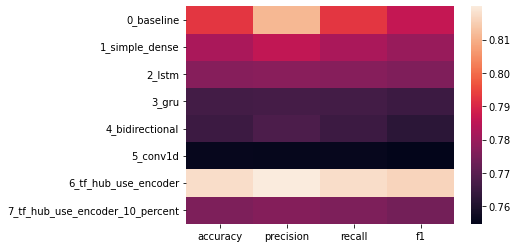

In [113]:
# Create the heatmap
import seaborn as sns
sns.heatmap(all_model_results)

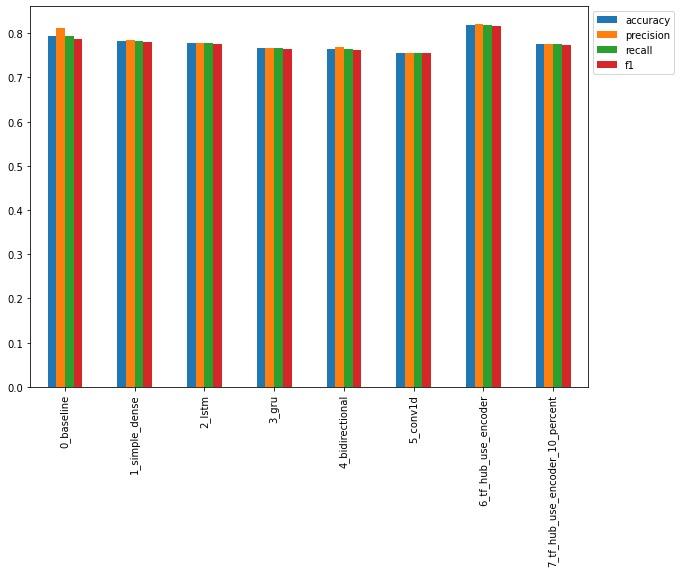

In [114]:
# Plot and compare all off the model results
all_model_results.plot(kind='bar',
                       figsize=(10,7)).legend(bbox_to_anchor=(1.0, 1.0))

<Axes: >

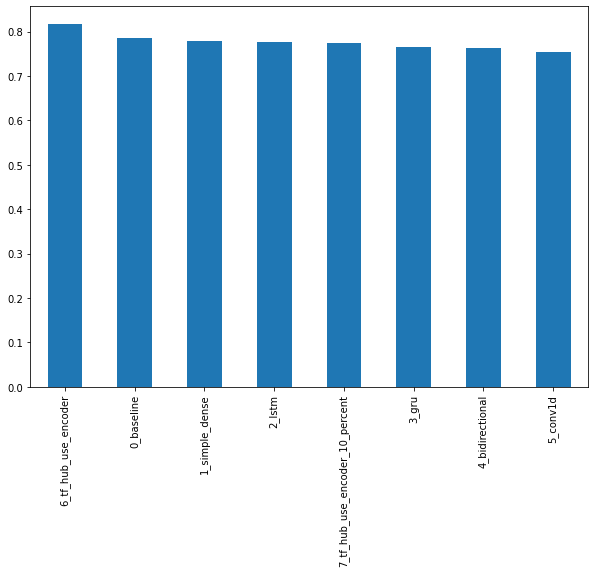

In [115]:
# Sort model results by f1-score
all_model_results.sort_values('f1', ascending=False)['f1'].plot(kind='bar', figsize=(10,7))

## Uploading our model training logs to tensorboard.dev
We can further inspect our model's performance using tensorboard.dev

In [116]:
# Uploading the model's performance data
!tensorboard dev upload --logdir ./model_logs/ \
  --name "NLP Modelling Experiments - along with @mdbourke" \
  --description "Comparing different types of model architecutres on Kaggle Tweets dataset" \
  --one_shot # exit the uploaded once uploading is finished

2023-03-23 19:21:43.206022: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/lib64-nvidia
2023-03-23 19:21:43.206133: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/lib64-nvidia
2023-03-23 19:21:43.206152: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.

***** TensorBoard Uploader *****

This will upload your TensorBoard logs to https://tensorboard.dev/ from
the following directory:

./model_logs/

This TensorBoard wi

In [117]:
# Checking all of the uploaded experiments
!tensorboard dev list

2023-03-23 19:26:59.276674: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/lib64-nvidia
2023-03-23 19:26:59.276768: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/lib64-nvidia
2023-03-23 19:26:59.276788: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.
https://tensorboard.dev/experiment/YwC3SaybQGy5eaLajbZiyg/
	Name                 NLP Modelling Experiments - along with @mdbourke
	Description          Comparing diffe

In [ ]:
# If you need to delete and experiment from TensorBoard, just run this command
#!tensorboard dev delete --experiment_id <id here>

>**NOTE:** TensorBoard is great for quick tracking experiments but for larger scale experiments and buch of additional tracking options, chek out Weights&Biases: https://wandb.ai/site

## Saving and loading a trained model
There are two main formats to save model to:
* HDF5
* `SavedModel` (default while saving with TensorFlow)

In [118]:
model_6_results

{'accuracy': 81.75853018372703,
 'precision': 0.8199411418946955,
 'recall': 0.8175853018372703,
 'f1': 0.8160820787192251}

In [119]:
# Save TF Hub sentence encoder to HDF5 format
model_6.save('model_6.h5')

In [120]:
# Load model with custom Hub Layer (required with HDF5 format)
import tensorflow_hub as hub

loaded_model_6 = tf.keras.models.load_model('model_6.h5',
                                            custom_objects={'KerasLayer': hub.KerasLayer})

In [122]:
# How does our loaded model perform?
loaded_model_6.evaluate(val_sentences, val_labels)

24/24 [==============================] - 2s 21ms/step - loss: 0.4243 - accuracy: 0.8176


[0.4242748022079468, 0.817585289478302]

Now let's save the model to the `SavedModel` format!

In [123]:
# Save TF Hub model to SavedModel format (the default)
model_6.save('model_6_SavedModel_format')

In [124]:
# Load in the model from SavedModel format
loaded_model_6_SavedModel_format = tf.keras.models.load_model('model_6_SavedModel_format')

In [125]:
# Evaluate model in SavedModel format
loaded_model_6_SavedModel_format.evaluate(val_sentences, val_labels)

24/24 [==============================] - 1s 20ms/step - loss: 0.4243 - accuracy: 0.8176


[0.4242748022079468, 0.817585289478302]

## Finding the most wrong examples
* If our best model still isn't perfect, what examples is it getting wrong?
* And of these wrong examples which ones is it getting *most* wrong (those with prediction probabilities closest to the opposite class)

For example if a sample should have a label of 0 but our model predicts prediction probability close to 1 and vice versa.

In [150]:
# Create a DataFrame with validation sentences, validation labels and best performing model predictions labels + probabilities
val_df = pd.DataFrame({'text': val_sentences,
                       'target': val_labels,
                       'pred': tf.squeeze(model_6_preds),
                       'probs': tf.squeeze(model_6_pred_probs)})

val_df.head()

,text,target,pred,probs
4955,DFR EP016 Monthly Meltdown - On Dnbheaven 2015...,0,0.0,0.162080
584,FedEx no longer to transport bioterror germs i...,0,1.0,0.785722
7411,Gunmen kill four in El Salvador bus attack: Su...,1,1.0,0.992081
5950,@camilacabello97 Internally and externally scr...,1,0.0,0.188281
5541,Radiation emergency #preparedness starts with ...,1,1.0,0.703581


In [153]:
# Find the wrong predictions and sort by prediction probabilities
most_wrong = val_df[val_df['target'] != val_df['pred']].sort_values('probs', ascending=False)
most_wrong[:10]

,text,target,pred,probs
1206,? High Skies - Burning Buildings ? http://t.co...,0,1.0,0.914240
4821,@noah_anyname That's where the concentration c...,0,1.0,0.888177
578,FedEx will no longer transport bioterror patho...,0,1.0,0.879634
3991,@madonnamking RSPCA site multiple 7 story high...,0,1.0,0.862490
6859,@AshGhebranious civil rights continued in the ...,0,1.0,0.849792
1186,Ashes 2015: AustraliaÛªs collapse at Trent Br...,0,1.0,0.848603
6213,[55436] 1950 LIONEL TRAINS SMOKE LOCOMOTIVES W...,0,1.0,0.834707
2145,Deaths 3 http://t.co/nApviyGKYK,0,1.0,0.832313
1195,@SonofLiberty357 all illuminated by the bright...,0,1.0,0.828865
166,My phone looks like it was in a car ship airpl...,0,1.0,0.801995


Let's remind ourselves of target labels: 
* `0` - not disaster
* `1` - disaster

In [154]:
# Tail end is as below
most_wrong[-10:]

,text,target,pred,probs
257,@willienelson We need help! Horses will die!Pl...,1,0.0,0.058252
4154,You can never escape me. Bullets don't harm me...,1,0.0,0.055640
2522,going to redo my nails and watch behind the sc...,1,0.0,0.053281
5574,'The way you move is like a full on rainstorm ...,1,0.0,0.051032
3272,Lucas Duda is Ghost Rider. Not the Nic Cage ve...,1,0.0,0.050774
6221,I get to smoke my shit in peace,1,0.0,0.043884
5464,Reddit Will Now QuarantineÛ_ http://t.co/pkUA...,1,0.0,0.042926
6160,@SoonerMagic_ I mean I'm a fan but I don't nee...,1,0.0,0.042683
2250,Why are you deluged with low self-image? Take ...,1,0.0,0.025862
1861,Ron &amp; Fez - Dave's High School Crush https...,1,0.0,0.025673
